## Object detection

In this case study, we will be knowing how to pre-trained models to do object detection

### Setup
- We will need 'pycocotools' package

- We need to have 'tensorflow/models' from github to get all the pre-trained models

In [1]:
!git clone --depth 1 https://github.com/tensorflow/models

fatal: destination path 'models' already exists and is not an empty directory.


- Now let's install the object detection package

In [2]:
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.

In [3]:
%%bash 
cd models/research
pip install .

ERROR: Directory '.' is not installable. Neither 'setup.py' nor 'pyproject.toml' found.


### Let's do the imports now
- Import tensorflow and other modules

In [4]:
%tensorflow_version 2.x
import tensorflow
tensorflow.__version__

'2.8.2'

In [5]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display

- Import the object detection modules

In [6]:
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

- Patches

In [7]:
# patch tf1 into `utils.ops`
utils_ops.tensorflow = tensorflow.compat.v1

# Patch the location of gfile
tensorflow.gfile = tensorflow.io.gfile

### Model prepration

#### **Variables**
- We will be using faster rcnn model by default. You can check out the entire list of models from here https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md

#### **Model loader**

In [8]:
def load_model(model_name):
  base_url = 'http://download.tensorflow.org/models/object_detection/'
  model_file = model_name + '.tar.gz'
  model_dir = tensorflow.keras.utils.get_file(
    fname=model_name, 
    origin=base_url + model_file,
    untar=True)

  model_dir = pathlib.Path(model_dir)/"saved_model"

  model = tensorflow.saved_model.load(str(model_dir))
  model = model.signatures['serving_default']

  return model

#### **Load the label map**
- Every category is mapped to a certain label. Let's load the file which contains all the mappings

In [9]:
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = 'models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [10]:
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
import pathlib
PATH_TO_TEST_IMAGES_DIR = pathlib.Path('models/research/object_detection/test_images')
TEST_IMAGE_PATHS = sorted(list(PATH_TO_TEST_IMAGES_DIR.glob("*.jpg")))
TEST_IMAGE_PATHS

[PosixPath('models/research/object_detection/test_images/image1.jpg'),
 PosixPath('models/research/object_detection/test_images/image2.jpg'),
 PosixPath('models/research/object_detection/test_images/image3.jpg')]

### Detection
- Let's load an object detection model

In [11]:
model_name = 'faster_rcnn_nas_coco_2018_01_28'
detection_model = load_model(model_name)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


- Let's see what kind of input this models takes

In [12]:
detection_model.inputs

[<tf.Tensor 'image_tensor:0' shape=(None, None, None, 3) dtype=uint8>]

- Let's see what this model outputs

In [13]:
detection_model.output_shapes

{'detection_boxes': TensorShape([None, 100, 4]),
 'detection_classes': TensorShape([None, 100]),
 'detection_scores': TensorShape([None, 100]),
 'num_detections': TensorShape([None])}

- Function to call the model and clean the output

In [14]:
def run_inference_for_single_image(model, image):
  image = np.asarray(image)
  # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
  input_tensor = tensorflow.convert_to_tensor(image)
  # The model expects a batch of images, so add an axis with `tf.newaxis`.
  input_tensor = input_tensor[tensorflow.newaxis,...]

  # Run inference
  output_dict = model(input_tensor)

  # All outputs are batches tensors.
  # Convert to numpy arrays, and take index [0] to remove the batch dimension.
  # We're only interested in the first num_detections.
  num_detections = int(output_dict.pop('num_detections'))
  output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections

  # detection_classes should be ints.
  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
   
  # Handle models with masks:
  if 'detection_masks' in output_dict:
    # Reframe the the bbox mask to the image size.
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])      
    detection_masks_reframed = tensorflow.cast(detection_masks_reframed > 0.5,
                                       tensorflow.uint8)
    output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
  return output_dict

- Function to display the results for each input

In [15]:
def show_inference(model, image_path):
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = np.array(Image.open(image_path))
  # Actual detection.
  output_dict = run_inference_for_single_image(model, image_np)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=8)

  display(Image.fromarray(image_np))

In [19]:
#for image_path in TEST_IMAGE_PATHS:
 # show_inference(detection_model, image_path)

Output hidden; open in https://colab.research.google.com to view.

If you want to detect objects in your own image, you can use the below code

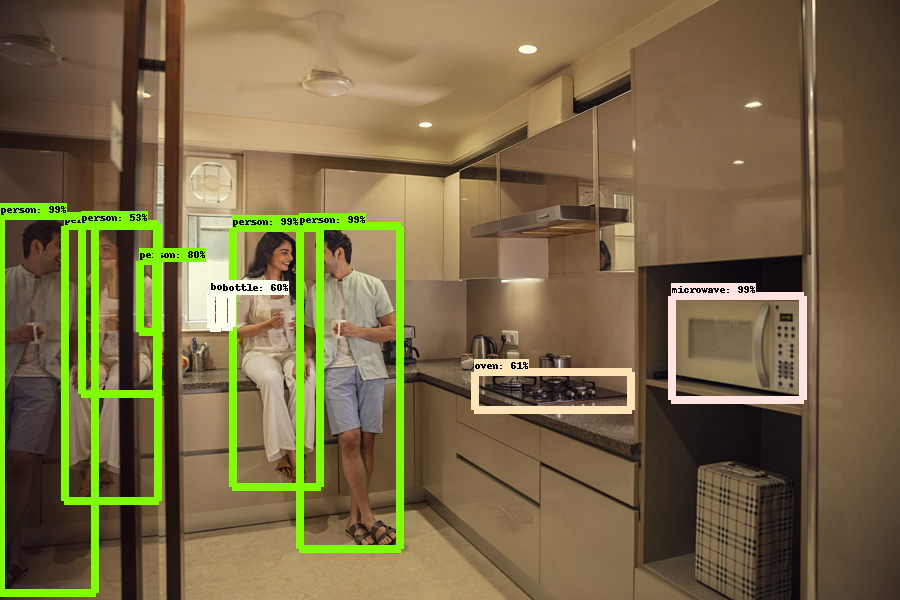

In [16]:
your_image_path = '/content/300-SM969973.jpg'
show_inference(detection_model, your_image_path)

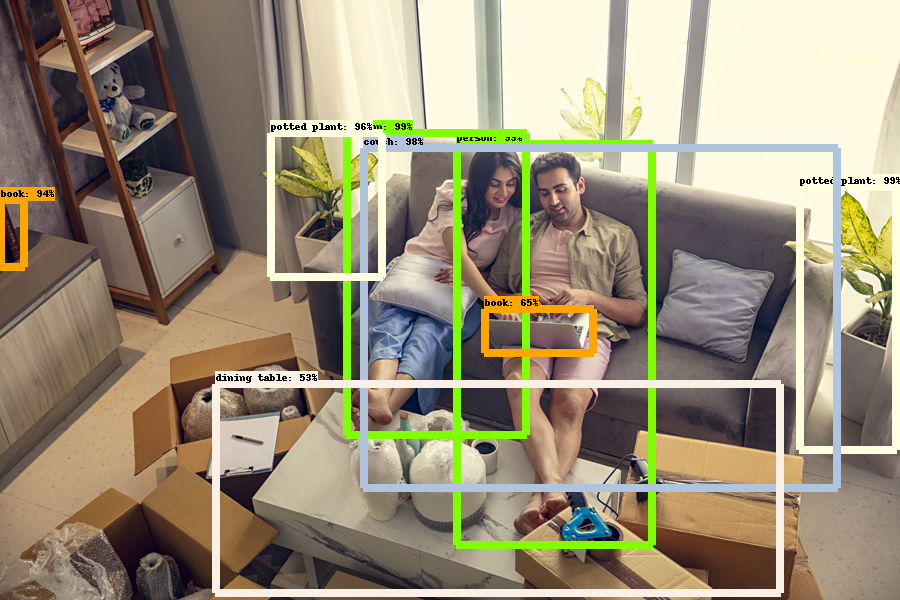

In [17]:
your_image_path = '/content/300-SM970366.jpg'
show_inference(detection_model, your_image_path)